安装所需要的dependencies

In [8]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import re
import os

import dashscope
from dashscope import TextEmbedding
from dashvector import Client, Doc

import json

from sklearn.metrics.pairwise import cosine_similarity
from dashscope import Generation

import fitz

from pysbd import Segmenter
from tqdm import tqdm


处理pdf文件

In [14]:
import fitz

from pysbd import Segmenter

segmenter = Segmenter()

def read_pdfs_to_list(folder_path):
    pdf_texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.pdf'):
            file_path = os.path.join(folder_path, filename)
            with fitz.open(file_path) as doc:
                full_text = ""
                for page in doc:
                    full_text += page.get_text()
                
                full_text = re.sub(r"\n", " ", full_text)
                full_text = re.sub(r"\xa0", " ", full_text)
                full_text = re.sub(r"- ", "", full_text)
                pdf_texts.append(segmenter.segment(full_text.lower()))
    return pdf_texts

folder_path = 'D:\\RexZhann\\nlp\\papers'


pdf_texts = read_pdfs_to_list(folder_path)


处理txt文件

In [15]:
segmenter = Segmenter()

def read_txts_to_list(folder_path):
    txt_texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                full_text = file.read()
                
                # 清理文本，替换换行符和非打印字符
                full_text = re.sub(r"\n", " ", full_text)
                full_text = re.sub(r"\xa0", " ", full_text)
                
                # 去除可能存在的其他不需要的字符或格式
                full_text = re.sub(r"- ", "", full_text)
                
                # 使用pysbd进行句子分割
                txt_texts.append(segmenter.segment(full_text.lower()))
    return txt_texts

folder_path = 'D:\\RexZhann\\nlp\\papers'

txt_texts = read_txts_to_list(folder_path)


输入关键词

In [16]:
keyword = 'dementia'

筛选出相关段落（窗口大小可以自行调整）

In [17]:
def find_related_sent(keyword, sentences):
    related_sent = []
    for sent_per_text in sentences:
        for i, sent in enumerate(sent_per_text):
            if keyword.lower() in sent.lower():
                for j in range(np.max([0, i - 5]), np.min([i + 5, len(sent_per_text)])):
                    if sent_per_text[j] not in related_sent:
                        related_sent.append(sent_per_text[j])
    return related_sent


articles = find_related_sent(keyword, txt_texts)
len(articles)

852

根据文本长度来决定要不要剪短

In [18]:
articles = articles[30:480]

In [10]:
dashscope.api_key='sk-b8ba4c6e0c9b4e7697fd3cdaaebe63f7'

def generate_embeddings(text):
    rsp = TextEmbedding.call(model=TextEmbedding.Models.text_embedding_v2,
                             input=text)
    embeddings = [record['embedding'] for record in rsp.output['embeddings']]
    return embeddings if isinstance(text, list) else embeddings[0]


In [9]:
def tokenizer_batch(articles, batchsize=6):
    def batch_generator(articles, batchsize):
        for i in range(0, len(articles), batchsize):
            yield articles[i:i + batchsize]
    
    tokenized_results = []
    
    with tqdm(total=len(articles) // batchsize + (len(articles) % batchsize > 0)) as pbar:
        for idx, batch in enumerate(batch_generator(articles, batchsize)):
            
            debug_info = f"Processing batch {idx + 1}/{len(articles) // batchsize + (len(articles) % batchsize > 0)} with {len(batch)} phrases"
            
            print(f"Debug: {debug_info}")  
            
            prompt = f'''complete the #OBJECTIVE# based on the #CONTEXT#, and generate the output based on #STYLE# and #RESPONSE#
            # CONTEXT #
            You are an professional and seasoned expert with 20 years experience of tokenizing text based on the deep connection 
            within context and dependency of the text, including extracting out any possible phrases and chunks of nouns. You are also
            good at recognizing the logical relation between the phrases in one context.
            # OBJECTIVE #
            tokenize these paragraphs by phrases and chunks of nouns:{' '.join(batch)}
            # STYLE #
            output only the result of tokenization, separated by quotation and comma, no linebreaks. Prefer chunks of nouns than 
            single nouns, try to output chunks of nouns when possible.
            # RESPONSE #
            do not output anything other than the result of tokenization, do not output too many single-word tokens. Do not output 
            complete sentences.Do not output any stopwords that's not part of a phrase.
            '''
            
            rsp = Generation.call(model='qwen-turbo', prompt=prompt)
            tokenized_results.append(rsp.output.text.strip())
            
            pbar.update(len(batch))  
    
    return tokenized_results


In [19]:
res = tokenizer_batch(articles)

phrases_llm = [re.findall(r'"(.*?)"', phrase) for phrase in res]



  0%|          | 0/75 [00:00<?, ?it/s]

Debug: Processing batch 1/75 with 6 phrases


  8%|▊         | 6/75 [00:01<00:15,  4.39it/s]

Debug: Processing batch 2/75 with 6 phrases


 16%|█▌        | 12/75 [00:02<00:15,  3.94it/s]

Debug: Processing batch 3/75 with 6 phrases


 24%|██▍       | 18/75 [00:05<00:20,  2.74it/s]

Debug: Processing batch 4/75 with 6 phrases


 32%|███▏      | 24/75 [00:07<00:16,  3.02it/s]

Debug: Processing batch 5/75 with 6 phrases


 40%|████      | 30/75 [00:09<00:14,  3.08it/s]

Debug: Processing batch 6/75 with 6 phrases


 48%|████▊     | 36/75 [00:10<00:11,  3.50it/s]

Debug: Processing batch 7/75 with 6 phrases


 56%|█████▌    | 42/75 [00:12<00:09,  3.55it/s]

Debug: Processing batch 8/75 with 6 phrases


对输出进行处理

In [ ]:
import nltk
from nltk.corpus import stopwords
from typing import List

# 确保已经下载了nltk的停用词列表
nltk.download('stopwords')

# 获取英文停用词列表，包括连词和介词
stop_words = set(stopwords.words('english'))

phrases_llm = [[phrase for phrase in phrases if len(phrase) <= 30 and len(phrase) > 4 and '%' not in phrase and phrase not in stop_words] for phrases in phrases_llm]
phrases_llm = [phrases for phrases in phrases_llm if len(phrases) != 0]
len(phrases_llm)

In [ ]:

client = Client(
  api_key='sk-0R9jI2212bV7Ma7u7ba4UmX8QQ8Gt2E2060C14D5411EF9A1EB61E393DC850',
  endpoint='vrs-cn-0mm3ulqnq00032.dashvector.cn-hangzhou.aliyuncs.com'
)


collection = client.get('sample1')
collection.delete(delete_all=True)  #清空collection
assert collection

In [ ]:
def batch_generator(items, batchsize):
    for i in range(0, len(items), batchsize):
        yield items[i:i + batchsize]

def process_phrases(phrases_llm, batchsize=6):
    for batch in batch_generator(phrases_llm, batchsize):
        
        for sent in batch:
            embeddings = [generate_embeddings(phrase) for phrase in sent]

            
            docs = [Doc(id=str(len(phrase)), vector=embedding, fields={"title": phrase}) 
                    for phrase, embedding in zip(sent, embeddings)]
        
        rsp = collection.insert(docs)
        assert rsp
process_phrases(phrases_llm, batchsize=5)


In [ ]:
rsp = collection.query(generate_embeddings(keyword), output_fields=['title'],topk=30)


related_phrases = [doc.fields['title'] for doc in rsp.output][4:20]
related_phrases_embeddings = [doc.vector for doc in rsp.output][4:20]


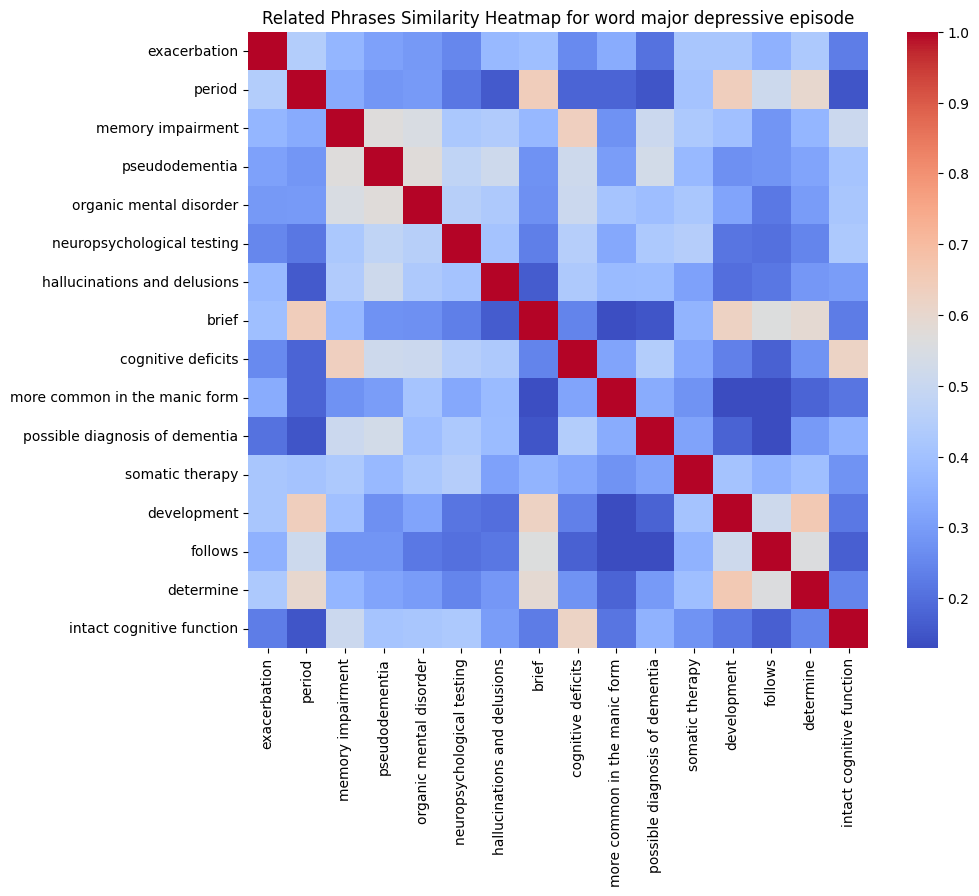

In [ ]:
related_phrases_embeddings = [generate_embeddings(phrase) for phrase in related_phrases]

similarity_matrix = cosine_similarity(related_phrases_embeddings)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=related_phrases, yticklabels=related_phrases, cmap='coolwarm')
plt.title(f'Related Phrases Similarity Heatmap for word {keyword}')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()